In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Comparison of Regressors for Abalone Age Prediction
In this assignment, the objective is to compare the performance of different regressors on the Abalone dataset. What is the best algorithm for the dataset?

In [14]:
abalone_data = pd.read_csv('data/abalone.data')
abalone_data.head()

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# Describe the dataset:
This dataset is supposed to predict the age of an abalone. The features contain information about the abalones gender and size.
the target tells how many rings the target has, which is used to determine the age in years.  
  
the uci link tells us that the missing values were removed from the dataset, and that the ranges of the continuous vales have been scaled.  
https://archive.ics.uci.edu/dataset/1/abalone

# encoding the categorical feature

In [15]:
label_encoder = LabelEncoder()

abalone_data['M'] = label_encoder.fit_transform(abalone_data['M'])

abalone_data.head()

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# Exploratory analysis of the dataset

array([[<Axes: title={'center': 'M'}>, <Axes: title={'center': '0.455'}>,
        <Axes: title={'center': '0.365'}>],
       [<Axes: title={'center': '0.095'}>,
        <Axes: title={'center': '0.514'}>,
        <Axes: title={'center': '0.2245'}>],
       [<Axes: title={'center': '0.101'}>,
        <Axes: title={'center': '0.15'}>, <Axes: title={'center': '15'}>]],
      dtype=object)

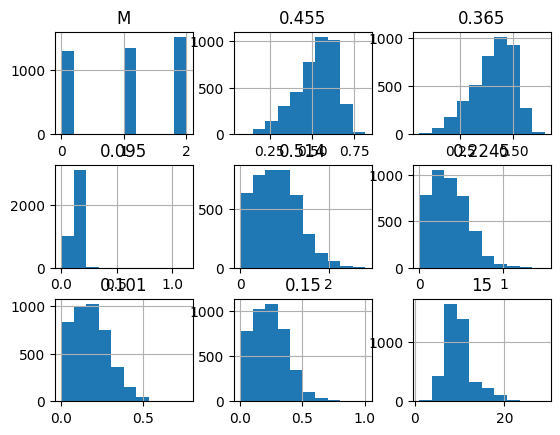

In [16]:
abalone_data.hist()

# Correlation
it looks like the features of the dataset are heavily correlated, beside the M feature. 

In [17]:
abalone_corr = abalone_data.corr()
abalone_corr.style.background_gradient(cmap='coolwarm')

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
M,1.000000,-0.035915,-0.038762,-0.041796,-0.021219,-0.001205,-0.031873,-0.034686,-0.035076
0.455,-0.035915,1.000000,0.986813,0.827552,0.925255,0.897905,0.903010,0.897697,0.557123
0.365,-0.038762,0.986813,1.000000,0.833705,0.925452,0.893159,0.899726,0.905328,0.575005
0.095,-0.041796,0.827552,0.833705,1.000000,0.819209,0.774957,0.798293,0.817326,0.558109
0.514,-0.021219,0.925255,0.925452,0.819209,1.000000,0.969403,0.966372,0.955351,0.540818
0.2245,-0.001205,0.897905,0.893159,0.774957,0.969403,1.000000,0.931956,0.882606,0.421256
0.101,-0.031873,0.903010,0.899726,0.798293,0.966372,0.931956,1.000000,0.907647,0.504274
0.15,-0.034686,0.897697,0.905328,0.817326,0.955351,0.882606,0.907647,1.000000,0.628031
15,-0.035076,0.557123,0.575005,0.558109,0.540818,0.421256,0.504274,0.628031,1.000000


# Necessary pre-processing of data

seeing how much cumulative variance is retained which every number of pca

[0.97818266 0.98844527 0.99579651 0.99806462 0.99954589 1.        ]


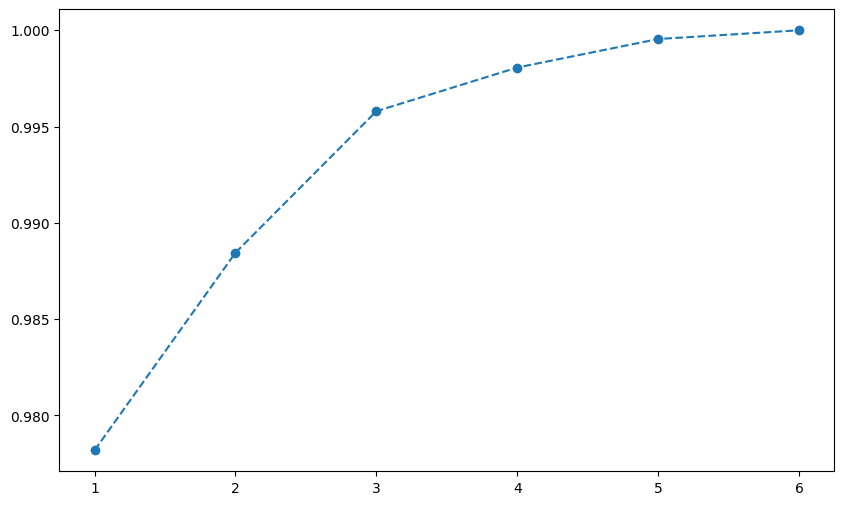

In [18]:
pca = PCA()
number_of_pca = pca.fit_transform(abalone_data.iloc[:, 1:7])
number_of_pca

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.show()

# hyperparameter tuning to find the best possible classifiers
i will be using nested cross validation for each algortihm that i am going to test, to make sure that i got the best combination of parameters. to evaluate during the tuning process i will be looking at accuracy, precision, recall and the f-measure and roc auc.

i will be first trying singular models, then ensemble models to see if a combination of models can give me a better result. 

i wil also be testing on the untuched data to see if the preprocessing made the data better better or not.

# 

# function for nested cross validation
it will return the best model for each outer cross validaiton loop

In [ ]:
def find_best_models(model, dt_params):
    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted']

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

    dt_cv_results = []
    dt_estimators = []
    dt_test_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
    }

    for (train_index, test_index) in list(outer_cv.split(features, targets)):

        dt_grid = GridSearchCV(model, dt_params, cv=inner_cv, scoring=metrics, refit='f1_weighted',return_train_score=True)
        dt_grid.fit(features.iloc[train_index], targets.iloc[train_index])

        cv_results = pd.DataFrame(dt_grid.cv_results_)
        dt_cv_results.append(cv_results)
        dt_estimators.append(dt_grid.best_estimator_)

        evaluation = evaluate(dt_grid, features.iloc[test_index], targets.iloc[test_index])
        dt_test_scores['accuracy'].append(evaluation['accuracy'])
        dt_test_scores['precision'].append(evaluation['precision'])
        dt_test_scores['recall'].append(evaluation['recall'])
        dt_test_scores['f1'].append(evaluation['f1'])
        dt_test_scores['roc_auc'].append(evaluation['roc_auc'])
    return dt_estimators, dt_cv_results, dt_test_scores



# function to evaluate a model
this will return the results of the model

In [ ]:

def evaluate(estimator, X, y):
    probabilities = estimator.predict_proba(X)
    prediction_indices = np.argmax(probabilities, axis=1)
    predictions = estimator.classes_.take(prediction_indices, axis=0)

    return{
        'accuracy': accuracy_score(y, predictions), 
        'precision': precision_score(y, predictions, average='weighted'), 
        'recall': recall_score(y, predictions, average='weighted'), 
        'f1': f1_score(y, predictions, average='weighted'), 
        'roc_auc': roc_auc_score(y, probabilities, multi_class="ovr")
    }

# singular models
i will first test which singular models give the best results, then test wether i should combine some of them or test ensembeled methods

# decision tree regressor